In [53]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter





In [54]:
######################################
# Path setup
######################################

current_path = os.getcwd()
current_path = current_path.replace("\\visualization", "")
current_path = current_path.replace("\\", "/")

base_path = f"{current_path}/output/full_optimization"
fig_path = f"{current_path}/visualization/figures"
sensor_path = f"{current_path}/sensor_data"

if not os.path.exists(fig_path):
    os.makedirs(fig_path)

folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

In [55]:
folders

['network_2corridor_initSearch_221014_08-09_multiple_seed-01',
 'network_2corridor_initSearch_221014_08-09_single_seed-01',
 'network_2corridor_initSearch_221014_08-09_single_seed-02',
 'network_2corridor_initSearch_221014_08-09_single_seed-03',
 'network_2corridor_saasbo_221014_08-09_single_seed-01',
 'network_2corridor_saasbo_221014_08-09_single_seed-02',
 'network_2corridor_saasbo_221014_08-09_single_seed-03',
 'network_2corridor_turbo_221014_08-09_multiple_seed-01',
 'network_2corridor_turbo_221014_08-09_single_seed-01',
 'network_2corridor_vanillabo_221014_08-09_multiple_seed-01',
 'network_2corridor_vanillabo_221014_08-09_single_seed-01',
 'network_2corridor_vanillabo_221014_08-09_single_seed-02']

In [56]:
######################################
# Input parameters
######################################

# max_iter_epoch_dict = {
#     '1ramp': 50,
#     '2corridor':200,
#     '3junction': 500,
#     '4smallRegion': 800,
#     '5fullRegion': 10
# }

# net_list_for_print = ['1ramp', '2corridor','3junction']

network_name = '2corridor' # '1ramp', '2corridor','3junction','4smallRegion','5fullRegion'
routes_per_od = 'single' # 'single', 'multiple'ArithmeticError
hour = '08-09'
date = '221014'
max_epoch = 3 

In [57]:
list_folder_name = [
    folder for folder in folders
    if network_name in folder and
       routes_per_od in folder and
       hour in folder and
       date in folder and
       'initSearch' not in folder
]
list_folder_name

['network_2corridor_saasbo_221014_08-09_single_seed-01',
 'network_2corridor_saasbo_221014_08-09_single_seed-02',
 'network_2corridor_saasbo_221014_08-09_single_seed-03',
 'network_2corridor_turbo_221014_08-09_single_seed-01',
 'network_2corridor_vanillabo_221014_08-09_single_seed-01',
 'network_2corridor_vanillabo_221014_08-09_single_seed-02']

In [62]:
net_name = f'{network_name}_'
model_list = [folder.split(net_name)[1].split('_')[0] for folder in list_folder_name if net_name in folder]
seeds_list = [folder.split('seed-')[1].split('_')[0] for folder in list_folder_name if 'seed-' in folder]
max_iter_epoch = max_epoch
print(model_list, seeds_list, max_epoch)

['saasbo', 'saasbo', 'saasbo', 'turbo', 'vanillabo', 'vanillabo'] ['01', '02', '03', '01', '01', '02'] 3


In [78]:
# Create a DataFrame from the lists
df = pd.DataFrame({
    'Folder': list_folder_name,
    'Model': model_list,
    'Seed': seeds_list
})
df

,Folder,Model,Seed
0,network_2corridor_saasbo_221014_08-09_single_s...,saasbo,01
1,network_2corridor_saasbo_221014_08-09_single_s...,saasbo,02
2,network_2corridor_saasbo_221014_08-09_single_s...,saasbo,03
3,network_2corridor_turbo_221014_08-09_single_se...,turbo,01
4,network_2corridor_vanillabo_221014_08-09_singl...,vanillabo,01
5,network_2corridor_vanillabo_221014_08-09_singl...,vanillabo,02


In [100]:
data_sets = {
    (df['Model'][idx], df['Seed'][idx]): pd.read_csv(
        f'{base_path}/{df['Folder'][idx]}/result/data_set.csv'
    ).query('epoch <= @max_iter_epoch')
    for idx in range(len(df))
}

In [ ]:
# #> Datasets
# unq_model_names = df['Model'].unique().tolist() 
# unq_seed_list =  df['Seed'].unique().tolist()

# print(unq_model_names, unq_seed_list)

['saasbo', 'turbo', 'vanillabo'] ['01', '02', '03']


##########

In [24]:
######################################
# Export dataset function
######################################

def get_seed_list(NET_NAME):
    
    seeds_list_return = [
        folder.split('sd-')[1].split('_')[0]
        for folder in folders if NET_NAME in folder and 'sd-' in folder
    ]
    
    return seeds_list_return


def network_name_to_dataSet(network_name):
    list_folder_name = [folder for folder in folders if f'network_{network_name}' in folder]


    net_name = f'{network_name}_'
    model_list = ['bo_highDim', 'bo_trustRegion', 'bo_vanilla', 'spsa']
    seeds_list = get_seed_list(network_name)
    max_iter_epoch = max_iter_epoch_dict.get(network_name, 1)
    
    #>
    selected_folder_name = [
            folder for folder in list_folder_name 
            if any(model in folder for model in model_list) and any(f'sd-{seed}_' in folder for seed in seeds_list)
        ]   

    #>
    models_in_list = [
            folder.split(net_name)[1].split('_od')[0] 
            for folder in selected_folder_name 
            if net_name in folder and any(f'sd-{seed}_' in folder for seed in seeds_list)
        ]   


    # Create a DataFrame from the lists
    df = pd.DataFrame({
        'Folder': selected_folder_name,
        'Model': models_in_list,
        'Seed': seeds_list
    })

    #> Datasets
    unq_model_names = df['Model'].unique().tolist() 
    unq_seed_list =  df['Seed'].unique().tolist()

     
    data_sets = {
        (model, seed): pd.read_csv(
            os.path.join(base_path, df[(df['Model'] == model) & (df['Seed'] == seed)]['Folder'].values[0], 'BO/result/data_set_total.csv')
        ).query('bo_iteration <= @max_iter_epoch')
        for model in unq_model_names for seed in unq_seed_list
    }
    
    return unq_model_names, unq_seed_list, data_sets, df

network_name: 1ramp


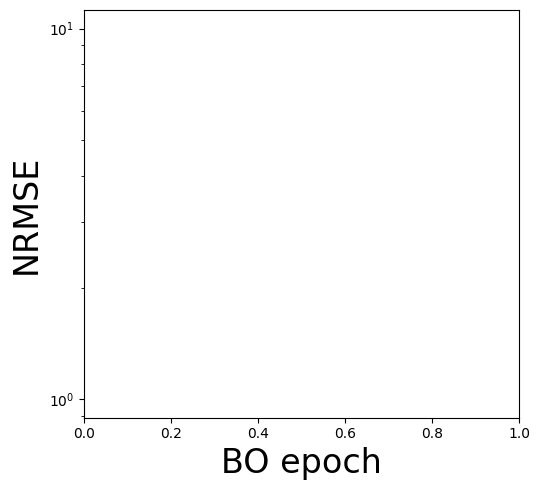

network_name: 2corridor


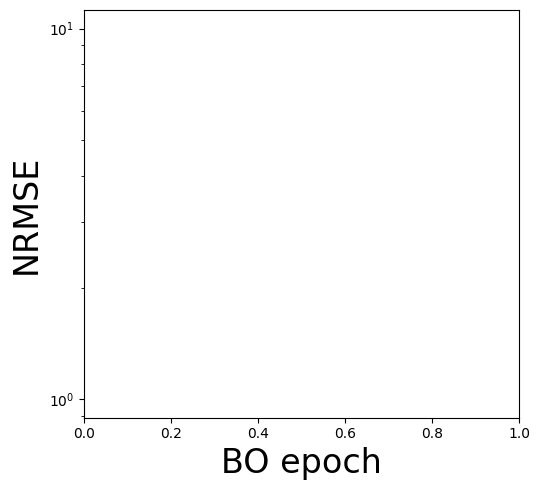

network_name: 3junction


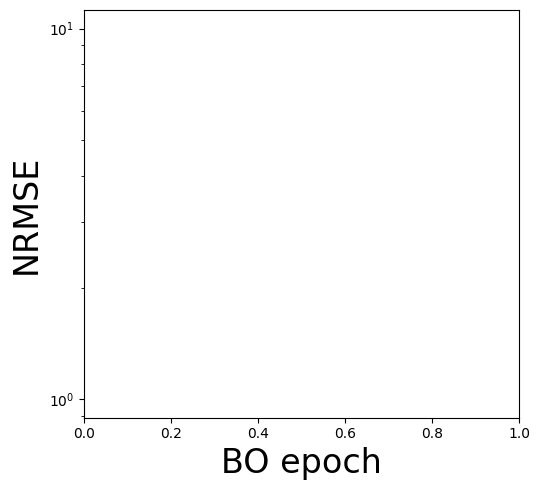

In [25]:

######################################
# C O N V E R G E N C E   P L O T S
######################################


for idx, NET_NAME in enumerate(net_list_for_print):
    model_names, seed_list, data_sets, df_net = network_name_to_dataSet(NET_NAME)
    print(f'network_name: {NET_NAME}')
    
    plt.figure(figsize=(5.5, 5))

    y_min = 0  
    y_max = float('-inf')


    for model in model_names:
        model_data = [data_sets[(model, seed)] for seed in seed_list]
        
        iterations = model_data[0]['bo_iteration']
        losses = np.array([data['loss'].cummin() for data in model_data])
        mean_loss = losses.mean(axis=0)
        std_loss = losses.std(axis=0)
        
        #> plt
        plt.plot(iterations, mean_loss, label=f"{model}", linewidth=1)
        
        plt.fill_between(iterations, mean_loss - 0.5 * std_loss, mean_loss + 0.5 * std_loss, alpha=0.3)
        
        y_max = max(y_max, mean_loss.max())

    plt.yscale('log')


    plt.xlabel('BO epoch', fontsize=24)
    plt.ylabel('NRMSE', fontsize=24)


    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(os.path.join(fig_path, f'convergence_plot_{NET_NAME}.png'), dpi=300)

    plt.show() 
    
    

c:/Users/TLSYSLAB_3_ADMIN/Documents/Git/bo-urbanmobility-test/output
network_name: 1ramp


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\TLSYSLAB_3_ADMIN\\Documents\\Git\\bo-urbanmobility-test\\figure\\convergence_plot_1ramp.png'

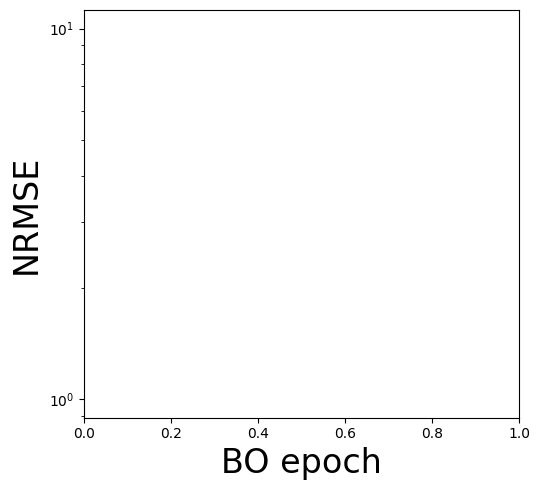

In [ ]:




######################################
# FIT to Ground Truth
######################################


def cal_min_max_vec(NET_NAME, DataSet, SensorCount):
    sensor_count_gt = pd.read_csv(f'{sensor_path}/gt_edge_data_{NET_NAME}-221014-from8to9.csv')

    glob_min_val = float('inf')
    glob_max_val = float('-inf')

    for model in model_names:
        for seed in seed_list:
            data_set_total = DataSet[(model, seed)]
            sensor_count_bo = SensorCount[(model, seed)]

            data_set_bo = data_set_total[data_set_total['bo_iteration'] > 0].reset_index(drop=True)
            data_set_bo_iter_best = data_set_bo.loc[data_set_bo.groupby('bo_iteration')['loss'].idxmin()].reset_index(drop=True)

            bo_result_iter_best_improve = data_set_bo_iter_best[["bo_iteration", "batch", "loss"]].copy()
            bo_result_iter_best_improve["best_value"] = bo_result_iter_best_improve["loss"].expanding().min()
            bo_result_iter_best_improve = bo_result_iter_best_improve[
                bo_result_iter_best_improve["loss"] == bo_result_iter_best_improve["best_value"]
            ].reset_index(drop=True)
            bo_result_iter_best_improve = bo_result_iter_best_improve.drop(columns=["best_value"])

            
            for idx, row in bo_result_iter_best_improve.iterrows():
                curr_bo_iteration = int(row['bo_iteration'])
                curr_batch = int(row['batch'])

                curr_sensor_count_bo = sensor_count_bo.query(
                    "bo_iteration == @curr_bo_iteration and batch == @curr_batch"
                )[['edge_id', 'interval_nVehContrib']]
                
                sensor_count_merged = sensor_count_gt.merge(
                    curr_sensor_count_bo,
                    on=['edge_id'],
                    how='left',
                    suffixes=('_gt', '_bo')
                )

                
                min_val = np.nanmin([
                    sensor_count_merged['interval_nVehContrib_gt'].min(), 
                    sensor_count_merged['interval_nVehContrib_bo'].min()
                ])
                
                
                max_val = np.nanmax([
                    sensor_count_merged['interval_nVehContrib_gt'].max(), 
                    sensor_count_merged['interval_nVehContrib_bo'].max()
                ])
                
                
                vec = np.arange(min_val, max_val)
                
            min_val = min(vec)
            max_val = max(vec)
            
            if min_val < glob_min_val:
                glob_min_val = min_val
            if max_val > glob_max_val:
                glob_max_val = max_val
            

    vec = np.arange(glob_min_val * 0.9, glob_max_val * 1.1)
    
    return vec  


def plot_fit_GT(NET_NAME, DataSet, SensorCount, VEC_element):
    sensor_count_gt = pd.read_csv(f'{sensor_path}/gt_edge_data_{NET_NAME}-221014-from8to9.csv')
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)


    if NET_NAME == '1ramp':
            network_name_append = 'Simple ramp'
    elif NET_NAME == '2corridor':
        network_name_append = 'One-way corridor'
    elif NET_NAME == '3junction':
        network_name_append = 'Junction'
    elif NET_NAME == '4smallRegion':
        network_name_append = 'Small region'
    
    

    for idx, model in enumerate(model_names):
        ax = axes[idx]
        
        if model == 'bo_highDim':
            model_append = 'SAASBO'
        elif model == 'bo_trustRegion':
            model_append = 'TuRBO' 
        elif model == 'bo_vanilla':
            model_append = 'Vanilla BO'
        elif model == 'spsa':
            model_append = 'SPSA'
        
        
        # Initialize a DataFrame to store the best solutions for all seeds
        combined_sensor_count = sensor_count_gt.copy()
        combined_sensor_count['interval_nVehContrib_bo'] = np.nan  # Add a column for simulated values
        
        combined_sensor_count_merged = pd.DataFrame()
        for seed in seed_list:  # Iterate over seeds
            combined_sensor_count = sensor_count_gt.copy()
            combined_sensor_count['interval_nVehContrib_bo'] = np.nan  # Add a column for simulated values
            
            data_set_total = DataSet[(model, seed)]
            sensor_count_bo = SensorCount[(model, seed)]

            # Filter the best solution for the current seed
            data_set_bo = data_set_total[data_set_total['bo_iteration'] > 0].reset_index(drop=True)
            data_set_bo_iter_best = data_set_bo.loc[data_set_bo.groupby('bo_iteration')['loss'].idxmin()].reset_index(drop=True)
            final_best = data_set_bo_iter_best.loc[data_set_bo_iter_best['loss'].idxmin()]

            curr_bo_iteration = int(final_best['bo_iteration'])
            curr_batch = int(final_best['batch'])

            # Get the sensor count for the best solution
            curr_sensor_count_bo = sensor_count_bo.query(
                "bo_iteration == @curr_bo_iteration and batch == @curr_batch"
            )[['edge_id', 'interval_nVehContrib']]

            # Merge with ground truth and update the combined DataFrame
            sensor_count_merged = sensor_count_gt.merge(
                curr_sensor_count_bo,
                on=['edge_id'],
                how='left',
                suffixes=('_gt', '_bo')
            )
            combined_sensor_count['interval_nVehContrib_bo'] = combined_sensor_count['interval_nVehContrib_bo'].combine_first(
                sensor_count_merged['interval_nVehContrib_bo']
            )
            combined_sensor_count_merged = pd.concat([combined_sensor_count_merged, combined_sensor_count], ignore_index=True)
            
        
        # Scatter plot with lines connecting points with the same 'interval_nVehContrib'
        for key, group in combined_sensor_count_merged.groupby('interval_nVehContrib'):
            ax.plot(VEC_element, VEC_element, 'r-', label="Perfect match", zorder=1)
            # Calculate mean and standard deviation for the group
            mean_bo = group['interval_nVehContrib_bo'].mean()
            std_bo = group['interval_nVehContrib_bo'].std()

            ax.scatter(
                key,  # x-coordinate is the GT value (key)
                mean_bo,  # y-coordinate is the mean of simulated values
                label=f"{model} - {key}",
                alpha=0.9,
                marker='o',
                s=50,  # Adjust the size of the scatter points
                zorder=2,
                color='black'
            )
            
            # Calculate alpha based on proximity to mean_bo
            alpha_values = 0.8 - 0.7 * (abs(group['interval_nVehContrib_bo'] - mean_bo) / (std_bo if std_bo != 0 else 1))
            alpha_values = alpha_values.clip(0.1, 1.0)  # Ensure alpha is between 0.1 and 1.0

            # Scatter plot with varying alpha
            ax.scatter(
                group['interval_nVehContrib'],
                group['interval_nVehContrib_bo'],
                alpha=alpha_values,
                marker='o',
                s=50,  # Adjust the size of the scatter points
                zorder=1,
                color='blue'
            )

            # Plot the error bar (standard deviation / 2)
            ax.plot(
                [key, key],  # x-coordinates for the vertical line
                [mean_bo - std_bo / 2, mean_bo + std_bo / 2],  # y-coordinates for the error range
                color='black',
                alpha=0.7,
                zorder=2
            )
            
        ax.set_xlabel('GT edge counts', fontsize=24)
        if idx == 0:
            ax.set_ylabel('Simulated edge counts', fontsize=24)
            ax.set_title(f'{network_name_append} | {model_append}', fontsize=24)
        else:
            ax.set_title(f' {model_append}', fontsize=24)
    
    plt.tight_layout()
    plt.savefig(os.path.join(fig_path, f'Fit_{NET_NAME}_1x4.png'), dpi=300)
    plt.show()



for idx, NET_NAME in enumerate(net_list_for_print):
    model_names, seed_list, data_sets, df_net = network_name_to_dataSet(NET_NAME)

    max_iter_epoch = max_iter_epoch_dict.get(NET_NAME, 1)

    
    
    data_set_total_all_model = {
        (model, seed): pd.read_csv(
            os.path.join(base_path, df_net[(df_net['Model'] == model) & (df_net['Seed'] == seed)]['Folder'].values[0], 'BO/result/data_set_total.csv')
        ).query('bo_iteration <= @max_iter_epoch')
        for model in model_names for seed in seed_list
    }

    # print(data_set_total_all_model.keys())

    sensor_count_bo_all_model = {
        (model, seed): pd.read_csv(
            os.path.join(base_path, df_net[(df_net['Model'] == model) & (df_net['Seed'] == seed)]['Folder'].values[0], 'BO/result/sensor_count_bo.csv')
        )
        for model in model_names for seed in seed_list
    }
 

    data_set_total_all_model_no_seed = data_set_total_all_model.copy()
    sensor_count_bo_all_model_no_seed = sensor_count_bo_all_model.copy()

    #> min, max 벡터 계산
    vec = cal_min_max_vec(NET_NAME, data_set_total_all_model, sensor_count_bo_all_model)
    
    
    #>
    plot_fit_GT(NET_NAME, data_set_total_all_model, sensor_count_bo_all_model, vec)
    
    
